<a href="https://colab.research.google.com/github/yuvalofek/py_xgboost/blob/main/Py_XGBoost_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing XGBoost in Python
XGBoost has been and is to this day one of the most popular and useful machine learning algorithms. In order to learn more about it, I decided to implement it!

Check out the official XGBoost paper here: https://arxiv.org/pdf/1603.02754.pdf


Other resources:
* [An End-to-End Guide to Understand the Math behind XGBoost](https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/?utm_source=blog&utm_medium=4-boosting-algorithms-machine-learning)
* [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/index.html)
* [StatQuest XGBoost](https://www.youtube.com/watch?v=OtD8wVaFm6E&list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ&ab_channel=StatQuestwithJoshStarmer)



In [135]:
import xgboost as xgb
import matplotlib.pyplot as plt


## Notes
* Scalable
* End-to-end
* weighted quantile for efficient proposal calculation
* sparcity aware algorithm
* cache aware block structure
* CART - space of regression trees 
* Uses Taylor expansion of the costum loss up to second order



For convenience, we opt to use MSE as a loss since it is common and to not worry about taking a Taylor expansion. 

In [136]:
class Node:
  def __init__(self, value, depth):
    self.value = value
    self.depth = depth
    self.gain = None
    self.left = None
    self.right = None

In [169]:
class XGBoostTree:
  def __init__(self, max_depth=6, gamma = 0, lambd=0):
    self.max_depth = max_depth
    self.root = None
    self.gamma = gamma
    self.lambd = lambd

  @staticmethod
  def __similarity(residuals, lambd=0):
    # Calculate similarity score of residuals
    return sum(residuals)/(len(residuals) + lambd)

  @staticmethod
  def __gain(right, left, root):
    # calculate gain
    return right + left - root

  def __get_split_greedy(self, X, y):
    # Get residuals
    if len(X) <= 1:
      return None, None

    # Compute G^2 / (H + lambda)
    avg = sum(y)/len(y)
    residuals = [avg-y_i for y_i in y]
    sim_root = self.__similarity(residuals, self.lambd)

    # sort residuals by x
    X, residuals = zip(*sorted(zip(X,residuals)))

    # Find split that results in least gain
    max_gain = -float('infinity')
    best_split = None
    for r in range(len(residuals)-1):
      split = sum(X[r:r+2])/2

      left = residuals[:r+1]
      # Compute G_L^2 / (H_L + lambda)
      sim_left = self.__similarity(left, self.lambd)

      # Compute G_R^2 / (H_R + lambda)
      right = residuals[r+1:]
      sim_right = self.__similarity(right, self.lambd)

      # Get the score
      g = self.__gain(sim_right, sim_left, sim_root)

      # Find min 
      if g > max_gain:
        max_gain = g
        best_split = split
    
    return best_split, max_gain

  def __fit(self, node, max_depth):
    """
    Recursively fit data 
    node - node object to fit to data, node.value contains data to fit
    depth - depth of node
    max_depth - maximum depth allowed
    """
    X, Y = zip(*node.value)
    split, gain = self.__get_split_greedy(X,Y)
    if split is None:
      # If there is no split --> one element, set prediction = label of element
      node.right = None
      node.left = None
      node.value = [Y[0]]
      return 
    
    if node.depth > max_depth:
      node.value = list(Y)
      return 

    # update node values
    node.value = split
    node.gain = gain

    # Build the rest of the tree
    node.right = Node([(x,y) for x, y in zip(X,Y) if x>node.value], node.depth+1)
    self.__fit(node.right,  max_depth)
    node.left = Node([(x,y) for x, y in zip(X,Y) if x<=node.value], node.depth+1)
    self.__fit(node.left, max_depth)

  def fit(self, X, Y):
    self.root = Node(zip(X,Y), 1)
    self.__fit(self.root, self.max_depth)
    if self.gamma is not None:
      self.prune()

  def __prune(self, node):
    """
    Recursive pruning using a gamma parameter
    """
    if node.left is None:
      # If leaf, return that it is pruned
      return True
    
    # prune children
    prune_left = self.__prune(node.left)
    prune_right = self.__prune(node.right)

    if ( prune_left and prune_right):
      # if we pruned both children, check for pruning
      if node.gain < self.gamma:
        # If need to prune, take the values of the children and store them, clean out node
        node.value = node.left.value + node.right.value
        node.left = None
        node.right = None
        node.gain = None
        return True
    return False

  def prune(self):
    self.__prune(self.root)

  def __print_tree(self, node):
    """
    Recursively print tree
    """
    if node.value is None:
      return
    print('    '*node.depth + str(node.value), f'({node.gain})')
    if node.left is not None:
      self.__print_tree(node.left)
      self.__print_tree(node.right)

  def print_tree(self):
    """ 
    call the recursive print using the tree root
    """
    self.__print_tree(self.root)

  def __get_output(self, Y):
    return sum(Y)/(len(Y)+self.lambd)

  def __predict(self, x, node):
    """
    Recursively predict label for input value x
    """
    if node.left is None:
      return self.__get_output(node.value)
    
    if x > node.value:
      return self.__predict(x, node.right)
    else:
      return self.__predict(x, node.left)

  def predict(self, X):
    """
    Predict labels for iterable X
    """
    y = []
    for x in X:
      y.append(self.__predict(x, self.root))
    return y



In [170]:
X = [10, 20, 21, 15,  25, 33, 35]
Y = [-10, 7, 7.5, 0, 8, -7, -8]

ex = XGBoostTree(max_depth=4, gamma=0.4, lambd=4)

ex.fit(X,Y)

In [171]:
ex.print_tree()

    12.5 (0.9642857142857141)
        [-10] (None)
        34.0 (0.8222222222222224)
            29.0 (0.7575000000000001)
                [0, 7, 7.5, 8] (None)
                [-7] (None)
            [-8] (None)


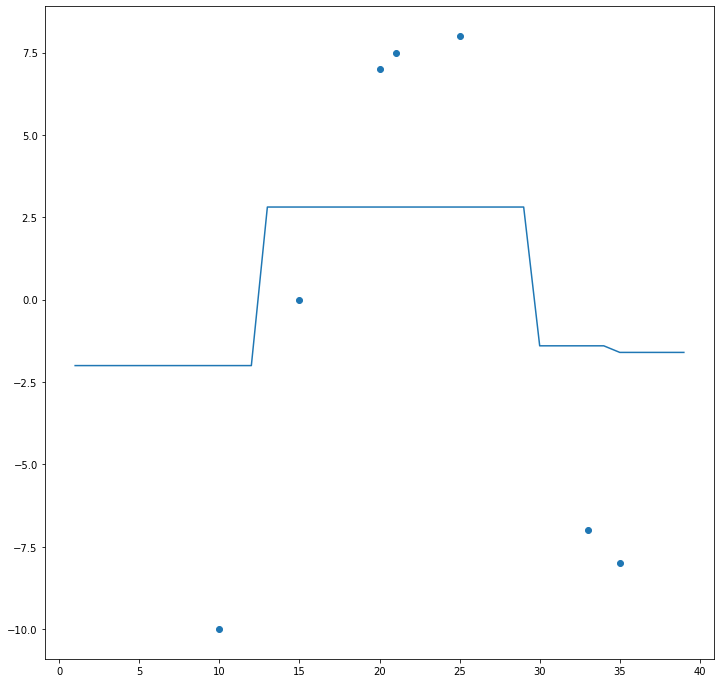

In [172]:
X_ = range(1, 40)
pred = ex.predict(X_)

plt.figure(figsize=(12,12))
plt.scatter(X,Y)
plt.plot(X_, pred)
plt.show()

## Checking with Other funcitons

In [184]:
import math
import numpy.random as npr

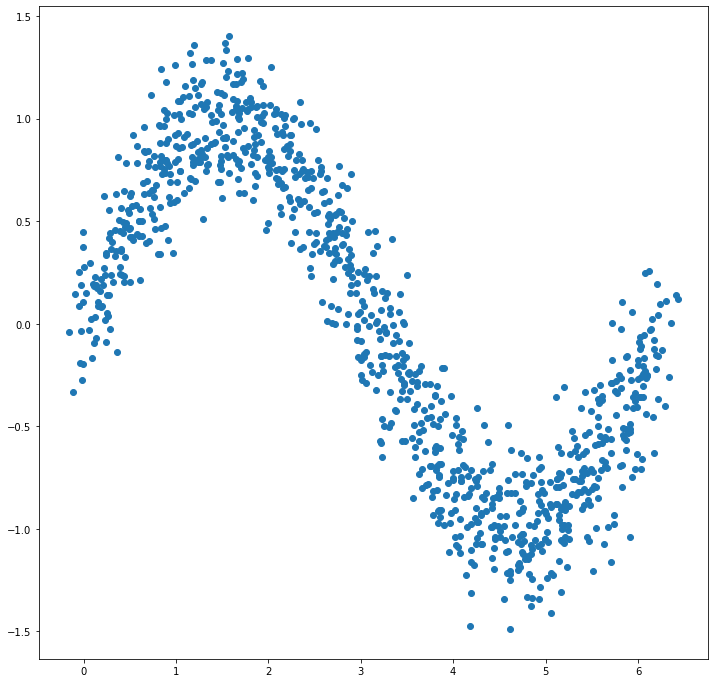

In [185]:
N = 1000
X_clean = [val/N*math.pi*2 for val in range(0, N)]
Y_clean = [math.sin(x) for x in X_clean]
noise_y = list(npr.normal(size=N)*.2)
noise_x = list(npr.normal(size=N)*.1)

X = [x+n for x,n in zip(X_clean, noise_x)]
Y = [y+n for y,n in zip(Y_clean, noise_y)]

plt.figure(figsize=(12,12))
plt.scatter(X, Y)
plt.show()

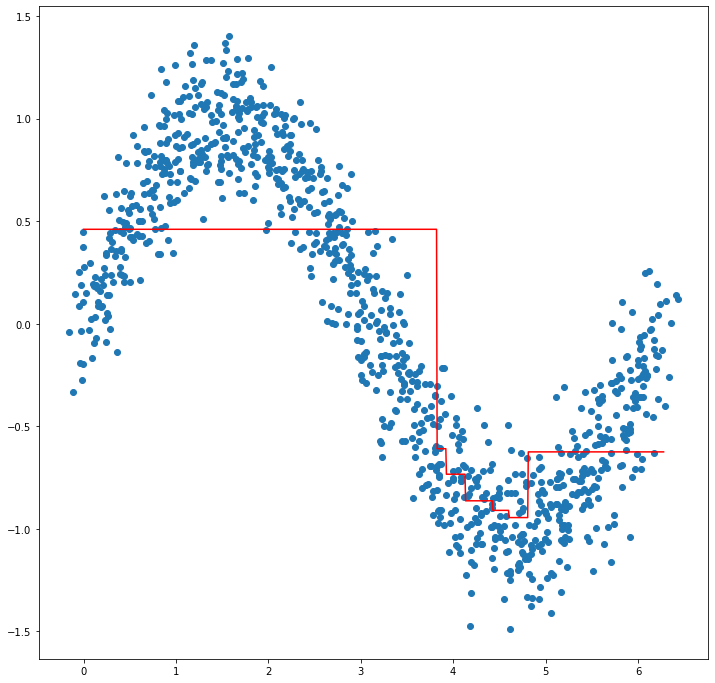

In [186]:
tr = XGBoostTree(max_depth=6, gamma=0.5, lambd=2)
tr.fit(X,Y)


plt.figure(figsize=(12,12))
plt.plot(X_clean, tr.predict(X_clean), 'red')
plt.scatter(X, Y)
plt.show()

In [187]:
tr.print_tree()

    4.8071903680159025 (0.4244772967792822)
        4.602801351424116 (1.0722657739997663)
            4.423660345015836 (1.0933472695069526)
                4.129058635354746 (1.0674250627691781)
                    3.922099123651975 (1.0187587344248767)
                        3.823927739324305 (0.9607001690492045)
                            [-0.19293838129470056, -0.038766776642618295, 0.08766286312091445, 0.19499535312884697, -0.33066819825483973, -0.2733160532266881, 0.14675147245085707, 0.29853732895836904, 0.6241914156111253, -0.0906866098434487, 0.10704644985314146, 0.15019220098124592, 0.27502645932319497, -0.03443120544122574, -0.16645732858897536, -0.19577470886373372, -0.09230725316168059, 0.03465288228158432, 0.18958296203255864, -0.028972235220745074, -0.06708364039102171, 0.25369585071312695, 0.018962962808312722, 0.3743977203708644, 0.13997013589437016, 0.08761820266228926, 0.44786472323730797, 0.2729361771307408, 0.13892203152185129, 0.03716321849024701, 0.17555343750